In [366]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tf.__version__

'2.1.0'

# Mục tiêu 
- Hiểu cách vận hành của một mạng fully connected nhiều lớp.
- Code bằng Tensorflow 2 (bài này dùng bản 2.1.0) với custom layer (tự build init weights, bias, loss function,...)
- Thực hành trên MNIST dataset của thư viện TensorFlow


## Phần 1 - Sơ bộ về Foward trong mạng Neural
*Không trình bày chi tiết về neural net*

Về cơ bản, chẳng hạn ta có một sample \\(x=(x_1, x_2)\\), hidden layer gồm có 4 node H như hình bên, và thêm vào đó là 1 bias. Ouput layer là một layer có 2 node (ứng với 2 giá trị ta muốn classify). Mỗi \\(x_i\\) có một kết nối \\(w_j\\) nào đó với một node \\(H\\).
![](https://theneuralperspective.files.wordpress.com/2016/10/screen-shot-2016-10-02-at-2-58-46-pm.png?w=550&h=318)

**Bước 1**: Tính toán các tổ hợp tuyến tính giữa \\(x\\) và \\(W_1\\), ở đây là phép nhân vô hướng giữa hai véc tơ (tích trong của \\(x\\) và \\(W_1\\)) cộng với bias, kết quả ký hiệu là \\(z\\).

In [477]:
# tạo véc tơ x là một tensor shape (1,2), giá trị lấy trong khoảng (-10, 10)
# tạo bias = 1
# seed ddể cố định việc tạo ra x, W_1 và W_2, phục vụ cho việc test ở sau.
np.random.seed(1)
x = np.random.randint(-10,10,(1,2))
b = 1
print(x)
print(b)

[[-5  1]]
1


véc tơ \\(x\\) có hai phần tử, thực hiện kết nối với 4 node \\(H\\), như vậy cần tạo ma trận \\(W_1\\) kích thước \\(1\times 4\\). Một cách tương tự, \\(W_2\\) có kích thước \\(4\times 2\\)

In [478]:
np.random.seed(2)
W_1 = np.random.random((2,4))
print(W_1)

[[0.4359949  0.02592623 0.54966248 0.43532239]
 [0.4203678  0.33033482 0.20464863 0.61927097]]


In [480]:
np.random.seed(3)
W_2 = np.random.random((4,2))
print(W_2)

[[0.5507979  0.70814782]
 [0.29090474 0.51082761]
 [0.89294695 0.89629309]
 [0.12558531 0.20724288]]


\\(z_1\\) là kết quả được tính bởi \\(x\\) và node \\(H\\) thứ 1

In [481]:
z_1 = np.dot(x, W_1[:,0]) + b
z_1

array([-0.75960671])

In [482]:
z_2 = np.dot(x, W_1[:,1]) + b
z_2

array([1.20070366])

Như vậy z là một tensor shape \\(1\times 4\\), ứng với các ouput tại các node \\(H\\).

In [483]:
z = np.dot(x, W_1) + b
z

array([[-0.75960671,  1.20070366, -1.54366376, -0.557341  ]])

**Bước 2**: Thực hiện kích hoạt giá trị \\(z\\) từ tuyến tính lên phi tuyến bằng cách áp lên nó một hàm kích hoạt (activation function), giá trị sau khi kích hoạt ký hiệu là a.

Có rất nhiều hàm kích hoạt trong deep, trong bài này, tôi dùng hàm sigmoid 

\\[f(x) = \dfrac{e^{-x}}{1+e^{-x}}\\]

In [484]:
def sigmoid(x):
    return np.exp(-x)/(1+np.exp(-x))
    

In [485]:
a_1 = sigmoid(z_1)
a_1

array([0.68126834])

In [486]:
a = sigmoid(z)
a

array([[0.68126834, 0.23135006, 0.8239967 , 0.63583708]])

**Bước 3**: Tính toán tương tự với output layer (lặp lại 2 bước 1 và 2). Bias b được dùng lại.

Do output layer có 2 node, ta sẽ dùng activation softmax như sau

\\[g(x_i) = \dfrac{e^{x_i}}{\sum_i e^{x_i}}\\]

In [487]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1)

Việc dùng Softmax có thể sinh ra các giá trị NaN (Not a Number), khắc phục bằng việc dùng softmax stable

In [639]:
def softmax_stable(Z):
    """
    Compute softmax values for each sets of scores in Z.
    each column of Z is a set of score.    
    """
    e_Z = np.exp(Z - np.max(Z,keepdims = True))
    A = e_Z / e_Z.sum(axis = 1)
    return A

In [488]:
zz = np.dot(a, W_2) + b
print('Giá trị của 2 node output trước khi kích hoạt:', zz)
aa = softmax_stable(zz)
print('Giá trị sau khi kích hoatj:', aa)

Giá trị của 2 node output trước khi kích hoạt: [[2.25817914 2.47093394]]
Giá trị sau khi kích hoatj: [[0.44701103 0.55298897]]


Dễ dàng kiểm tra được tổng của các phần tử của aa là 1, có thể hiểu đơn giản là 2 node của output layer đóng vai trò như là 2 class, và giá trị sau khi kích hoạt chính là các xác suất mà \\(x\\) thuộc vào 2 class đó. Lẽ dĩ nhiên, lớp nào có xác suất lớn hơn thì khả năng \\(x\\) thuộc vào lớp đó cao hơn.

In [489]:
np.sum(aa)

1.0

### Thực hiện trên TensorFlow 

In [490]:
class FC_layer(object):
    """A simple fully-connected NN layer.
    Args:
    num_inputs (int): Kích thước của véc tơ input (số phần tử của vecto x)
    layer_size (int): Kích thước của layer (số node)
    activation_fn (callable): Hàm kích hoạt
    Attributes:
    W (ndarray): Giá trị weights khởi tạo
    b (ndarray): Giá trị bias khởi tạo
    activation_fn (callable): Như trên
    """
    def __init__(self, num_inputs, layer_size, activation_fn):
        super().__init__()
        self.W = np.random.random((num_inputs, layer_size))
        self.b = 1
        self.activation_fn = activation_fn
        
    def forward(self,x):
        z = np.dot(x, self.W) + self.b
        a = self.activation_fn(z)
        return a
        
    

In [492]:
np.random.seed(2)
layer1 = FC_layer(2,4,sigmoid)

In [493]:
np.random.seed(1)
x = np.random.randint(-10,10,(1,2))
x

array([[-5,  1]])

In [494]:
layer1.forward(x)

array([[0.68126834, 0.23135006, 0.8239967 , 0.63583708]])

In [495]:
print(a == layer1.forward(x))

[[ True  True  True  True]]


Kết quả này giống với kết quả của \\(a\\), lúc này ta lập trình cho fully connected layer với nhiều lớp

In [496]:
class Network(object):
    """A simple fully-connected NN layer.
    Args:
    num_inputs (int): Kích thước của véc tơ input (số phần tử của vecto x)
    num_outputs (int): Kích thước của véc tơ output (số class cần phân loại)
    hidden_layers_sizes (list): Danh sách các kích thước của các hidden layer 
    Attributes:
    sizes: Danh sách kích thước của các layer
    layers: Danh sách các layer 

    """
    def __init__(self, num_inputs, num_outputs, hidden_layers_sizes):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.hidden_layers_sizes = hidden_layers_sizes
        # list các node ứng với các layer
        sizes = [num_inputs, *hidden_layers_sizes, num_outputs]
        # tạo ra list các layer tiện cho việc tính toán, không có layer cuối (softmax layer)
        self.layers = [FC_layer(sizes[i], sizes[i+1], sigmoid) for i in range(len(sizes)-2)]
        self.sizes = sizes
        
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        # thực hiện softmax ở layer cuối
        out = FC_layer(self.sizes[-2], self.sizes[-1], softmax_stable).forward(x)
        return out
    

In [497]:
np.random.seed(2)
net = Network(2,2,[4])

In [498]:
for layer in net.layers:
    print(layer.W == W_1)

[[ True  True  True  True]
 [ True  True  True  True]]


In [501]:
np.random.seed(3)
result = net.forward(x)

In [502]:
result

array([[0.44701103, 0.55298897]])

Kết quả này giống với aa như ở phần trên 

In [503]:
print(result==aa)

[[ True  True]]


## Sơ bộ về Backward trong mạng Neural

Có hai hàm loss được nhắc đến trong phần này

- MSE (Mean Square Error): \\[MSE(y^t, y) = \dfrac{1}{N}\sum_i (y^t_i-y_i)^2,\\] trong đó \\(y^t\\) là giá trị đúng (ground truth hay label), \\(y\\) là giá trị có được sau một loạt các tính toán (logits)
- BCE (Binary Cross Entropy): \\[BCE(y^t, y) = -\dfrac{1}{N}\sum_i y^t_i\log(y_i)+(1-y^t_i)\log(1-y_i)\\]

Để minh họa tính toán cho phần Backward, tôi sẽ dùng MSE cho việc tính đạo hàm được đơn giản. Tuy vậy BCE lợi thế hơn hẳn vì nó là độ đo sai lệch giữa 2 phân bố, trong khi MSE chỉ đo về khoảng cách là chủ yếu.

Phần code sẽ sử dụng cả hai hàm này để so sanhs

### chain rule
đơn giản là đạo hàm của hàm hợp, thực hiện tính toán cập nhật trọng số trong giải thuật gradient descent.

![](https://andymath.com/wp-content/uploads/2019/08/chain-rule.jpg)

*Một lần nữa, bài viết không tập trung giải thích lý thuyết về gradient descent, nó khá dễ hiểu và cũng có nhiều tài liệu đã viết*.

![](gradient_descent.png)

Trong giải thuật này, ta cần cập nhật 2 loại trọng số , đó là \\(W\\) và \\(b\\).

Xét tại layer thứ \\(k\\), ta có input, output, weights, bias của layer đó lần lượt là \\(x_k, a_k, W_k, b_k\\). Lẽ dĩ nhiên, output của layer thứ \\(k\\) là input của layer \\(k+1\\), do đó theo chain rule
\\[\frac{d L}{d W_{k}}=\frac{d L}{d a_{k}} \frac{d a_{k}}{d W_{k}}=\frac{d L}{d a_{k}} \frac{d a_{k}}{d z_{k}} \frac{d z_{k}}{d W_{k}}=\frac{d L}{d x_{k+1}} \frac{d a_{k}}{d z_{k}} \frac{d\left(W_{k} \cdot x_{k}+b_{k}\right)}{d W_{k}}=l_{k+1}^{\prime} \odot f_{k}^{\prime} \frac{d\left(W_{k} \cdot x_{k}+b_{k}\right)}{d W_{k}}=x_{k}^{\top} \cdot\left(l_{k+1}^{\prime} \odot f_{k}^{\prime}\right)\\]

Trong đó 
- \\(l'_{k+1}\\) là đạo hàm được tính cho layer \\(k+1\\) ứng với input \\(x_{k+1}\\).
- \\(f'_k\\) là đạo hàm của activation function.
- \\(x_T\\) là chuyển vị của \\(x\\)

Ký hiệu \\(\odot\\) là tích hadamard 
\\[\left(\begin{array}{ll}
a_{0} & a_{1} \\
a_{2} & a_{3}
\end{array}\right) \odot\left(\begin{array}{ll}
b_{0} & b_{1} \\
b_{2} & b_{3}
\end{array}\right)=\left(\begin{array}{llll}
a_{0} \times b_{0} & a_{1} \times b_{1} \\
a_{2} \times b_{2} & a_{3} \times b_{3}
\end{array}\right)\\]

Một cách tương tự, tính toán đạo hàm của hàm loss ứng với biến số bias
\\[\dfrac{d L}{d b_{k}}=\dfrac{d L}{d a_{k}} \dfrac{d a_{k}}{d b_{k}}=\dfrac{d L}{d a_{k}} \dfrac{d a_{k}}{d z_{k}} \dfrac{d z_{k}}{d b_{k}}=l_{k+1}^{\prime} \odot f_{k}^{\prime} \frac{d\left(W_{k} \cdot x_{k}+b_{k}\right)}{d b_{k}}=1^T \cdot l_{k+1}^{\prime} \odot f_{k}^{\prime}\\]

Thêm vào đó
\\[\frac{d L}{d x_{k}}=\frac{d L}{d a_{k}} \frac{d a_{k}}{d x_{k}}=\frac{d L}{d a_{k}} \frac{d a_{k}}{d z_{k}} \frac{d z_{k}}{d x_{k}}=l_{k+1}^{\prime} \odot f_{k}^{\prime} \frac{d\left(W_{k} \cdot x_{k}+b_{k}\right)}{d x_{k}}=W_{k}^{\top} \cdot\left(l_{k+1}^{\prime} \odot f_{k}^{\prime}\right)\\]


### Code trên TensorFlow

- *: phép nhân trên python, nhân kiểu hadamard, có tính đối xứng
- np.multiply: phép nhân trên numpy, nhân kiểu hadamard, có tính đối xứng
- np.matmul: Phép nhân ma trận
- np.dot: Phép nhân véc tơ và ma trận

In [594]:
x = np.array([[1,2],[3,4]], dtype=np.float64)
y = np.array([[5,6],[7,8]], dtype=np.float64)
z = np.array([[1,2],[3,4], [5,6]]).T
t = np.array([[1,2]])

# print(x * y)
# print(np.multiply(x, y))

# print(x * t)
# print(np.multiply(x, t))

print(np.matmul(x,y))
print(np.matmul(y,x))
print(np.dot(x,y))
print(np.dot(y,x))
             
print(np.matmul(x,z))
print(np.dot(x,z))

[[19. 22.]
 [43. 50.]]
[[23. 34.]
 [31. 46.]]
[[19. 22.]
 [43. 50.]]
[[23. 34.]
 [31. 46.]]
[[ 5. 11. 17.]
 [11. 25. 39.]]
[[ 5. 11. 17.]
 [11. 25. 39.]]


In [507]:
def sigmoid(x):     # sigmoid function
    return 1 / (1 + np.exp(-x))

def derivated_sigmoid(y):   # sigmoid derivative function: y' = y(1-y)
    return y * (1 - y)

def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1)

def softmax_stable(z):
    e = np.exp(z-np.max(z))
    s = np.sum(e, axis=1, keepdims=True)
    return e/s

def mse_loss(label, pred):
    return np.sum((label-pred)**2)/pred.shape[0]

def derivative_mse(label, pred):
    return 2*(label-pred) # biến là pred, không chia cho N bởi vì không ảnh hưởng nhiều đến kết quả.

def binary_cross_entropy(label, pred):            # cross-entropy loss function
    return -np.mean(np.multiply(np.log(pred), label) + np.multiply(np.log(1 - pred), (1 - label)))

def derivated_binary_cross_entropy(label, pred):  # cross-entropy derivative function
    return (pred - label) / (pred * (1 - pred))

Bây giờ ta tiến hành code một layer fully connected đầy đủ forward và backward để có thể optimize W và b, bằng SGD qua từng batch (khi thực hành trên MNIST dataset) trên layer đó. Ở đây ta dùng sigmoid là activation cho mọi layer). Phần optimize đơn giản là áp dụng giải thuật Gradient Descent.

In [601]:
class FC_layer_complete(object):
    def __init__(self, num_inputs, layer_size, activation_fn=sigmoid, d_activation_fn=derivated_sigmoid):
        super().__init__()
        self.W = np.random.standard_normal((num_inputs, layer_size))
        self.b = np.random.standard_normal(layer_size)
        self.activation_fn = activation_fn
        self.d_activation_fn = d_activation_fn
        
        self.x, self.a, self.dL_dW, self.dL_db = None, None, None, None
    def forward(self,x):
        z = np.dot(x, self.W) + self.b
        self.a = self.activation_fn(z)
        self.x = x # giữ giá trị x lại để dùng cho backward
        return self.a
    def backward(self, dL_da):
#         print(dL_da.shape)
        da_dz = self.d_activation_fn(self.a) # f'
#         print(da_dz.shape)
        dL_dz = dL_da * da_dz # l'* f'
        dz_dw = np.transpose(self.x) # x^T
        dz_dx = np.transpose(self.W) # W^T
        dz_db = np.ones(dL_da.shape[0])
        
        self.dL_dW = np.dot(dz_dw, dL_dz)
        self.dL_db = np.dot(dz_db, dL_dz)
        
        dL_dx = np.dot(dL_dz, dz_dx)
        return dL_dx
    
    def optimize(self, ep):
        self.W -= ep*self.dL_dW
        self.b -= ep*self.dL_db
        

Ta tạo một `class Network_complete`, thêm phương thức `evaluate_accuracy` để đánh giá accuracy trên tập test sau mỗi epoch.

Phương thức `train` được tiến hành như sau:
    - Lặp qua từng epoch, ở mỗi epoch lại lặp qua từng batch, mỗi batch có 32 samples.
    - Ta shuffle và tạo batch cho data train (32 samples), sau đó tiến hành train và cập nhật trọng số trên
    từng layer ứng với batch đó, đây gọi là mini batch GD.

In [614]:
class Network_complete(object):
    def __init__(self,num_inputs,num_outputs,hidden_layers_sizes,loss_fn=binary_cross_entropy,
                 d_loss_fn=derivated_binary_cross_entropy):
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.hidden_layers_sizes = hidden_layers_sizes
        self.loss_fn = loss_fn
        self.d_loss_fn = d_loss_fn
        # list các node ứng với các layer
        sizes = [num_inputs, *hidden_layers_sizes, num_outputs]
        self.layers = [FC_layer_complete(sizes[i], sizes[i+1]) for i in range(len(sizes)-1)]
#         self.sizes = sizes
        
    def forward_net(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward_net(self,dL_da):
        for layer in reversed(self.layers):
            dL_da = layer.backward(dL_da)
        return dL_da
    
    def optimize_net(self, ep):
        for layer in self.layers:
            layer.optimize(ep)
    def evaluate_accuracy(self, x_val, y_val):
        num_corrects = 0
        for i in range(len(x_val)):
            pred = np.argmax(self.forward_net(x_val[i]))
#             print(pred)
#             print(y_val[i])
            if pred == y_val[i]:
                num_corrects+=1
        return num_corrects/len(x_val)
    
    def train(self, x_train, y_train, x_val, y_val, batch_size = 32, n_epochs=10,learning_rate=5e-3):
        n_batches_per_epoch = int(len(x_train)/batch_size)
        losses, val_accuracies = [], []
    
        for i in range(n_epochs):
            epoch_loss = 0
#             shuffle data
            indexes = np.random.permutation(len(x_train))
            
            for b in range(n_batches_per_epoch):
                # tạo batch:
                b_idx_begin = b*batch_size
                b_idx_end = b_idx_begin + batch_size
                indexes_container = indexes[b_idx_begin:b_idx_end]
                
                x, y = x_train[indexes_container], y_train[indexes_container]
                
                # optimize
                a = self.forward_net(x)
                dL_da = self.d_loss_fn(label=y, pred=a)
                self.backward_net(dL_da)
                self.optimize_net(ep=learning_rate)
                epoch_loss += self.loss_fn(label=y,pred=a)
            epoch_loss/=n_batches_per_epoch
            losses.append(epoch_loss)
            val_acc = self.evaluate_accuracy(x_val, y_val)
            val_accuracies.append(val_acc)
            print("epoch: {} -- training loss={:.6f} -- val accuracy={:.2f}".format(i+1, epoch_loss, val_acc))
        return losses, val_accuracies
                

In [615]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.utils import to_categorical
def preprocessing_data():
    (x_train, y_train), (x_test, y_test) = load_data()
    x_train, x_test = x_train.astype('float32')/255., x_test.astype('float32')/255.
    x_train, x_test = x_train.reshape((-1, 28*28)), x_test.reshape((-1, 28*28))
    y_train = to_categorical(y_train)
    return (x_train, y_train), (x_test, y_test)
    

In [621]:
(x_train, y_train), (x_test, y_test) = preprocessing_data()

In [622]:
x_train.shape

(60000, 784)

In [623]:
n_classes = 10

mnist_net = Network_complete(x_train.shape[1], n_classes, [64, 32])

In [624]:
losses, accuracies = mnist_net.train(x_train, y_train, x_test, y_test)

epoch: 1 -- training loss=0.161560 -- val accuracy=0.85
epoch: 2 -- training loss=0.085164 -- val accuracy=0.89
epoch: 3 -- training loss=0.067998 -- val accuracy=0.90
epoch: 4 -- training loss=0.059162 -- val accuracy=0.91
epoch: 5 -- training loss=0.053312 -- val accuracy=0.92
epoch: 6 -- training loss=0.048876 -- val accuracy=0.92
epoch: 7 -- training loss=0.045440 -- val accuracy=0.93
epoch: 8 -- training loss=0.042690 -- val accuracy=0.93
epoch: 9 -- training loss=0.040216 -- val accuracy=0.93
epoch: 10 -- training loss=0.038245 -- val accuracy=0.93


In [636]:
def plot(data):
    plt.figure(figsize=(10,5))
    if data == 'losses':
        plt.title('Training Loss')
        plt.ylabel('Loss')
        plt.plot(range(10), [losses[i] for i in range(10)])
    if data == 'accuracies':
        plt.title('Validation Accuracy')
        plt.ylabel('Accuracy')
        plt.plot(range(10), [accuracies[i] for i in range(10)])
    plt.xlabel('Epoch')
    plt.show()
    

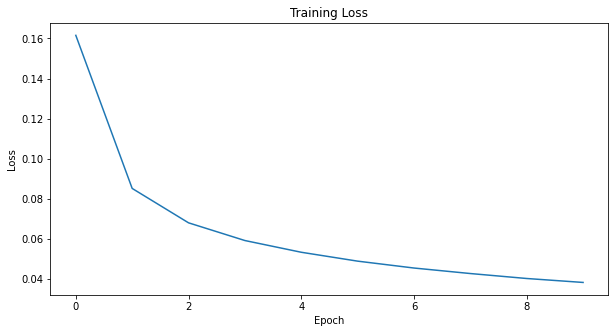

In [637]:
plot('losses')

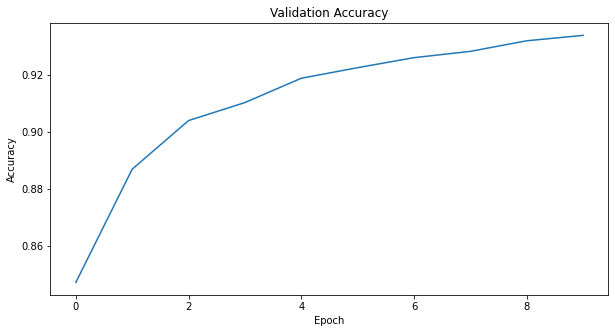

In [638]:
plot('accuracies')

## TÀI LIỆU THAM KHẢO

- [1] https://machinelearningcoban.com/2017/02/24/mlp/

- [2] https://aayushmnit.github.io/posts/2018/06/Building_neural_network_from_scratch/

- [3] https://github.com/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2